<a href="https://colab.research.google.com/github/HimanshuPant7/Crack_Segmentation/blob/main/Deep_crack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Crack Segmentation on deep crack dataset**.

## Importing the neccessary libraries and mounting the google drive (**)

In [ ]:
import os
import cv2
import shutil
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
import zipfile
import random
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import int_shape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, UpSampling2D, Add, BatchNormalization, Input, Activation, Concatenate, Conv2DTranspose, average, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from albumentations import Compose, OneOf, Flip, Rotate, RandomContrast, RandomGamma, RandomBrightness, ElasticTransform, GridDistortion, OpticalDistortion, RGBShift, CLAHE
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from skimage.transform import resize
from sklearn.metrics import classification_report
Train = 0
batch_size = 10
img_dim=(256, 256)



from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Generator function (**)
* A custom generator is created which combines the  image with its repective masks.
* All data is augmented using albumentation library. 
* Random flips and rotations along with more attributes of the albumentation library are used to augment the images present in the training data

In [ ]:
class Generator(Sequence):

  def __init__(self, x_set, y_set, batch_size=5, img_dim=(128, 128), augment=False):
      self.x = x_set
      self.y = y_set
      self.batch_size = batch_size
      self.img_dim = img_dim
      self.augment = augment

  def __len__(self):
      return math.ceil(len(self.x) / self.batch_size)

  augmentations = Compose(
    [                   
      Flip(p=0.7),
      Rotate(p=0.7),
      OneOf([
              RandomContrast(),
              RandomGamma(),
              RandomBrightness()
            ], p=0.3),
      OneOf([
              ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
              GridDistortion(),
              OpticalDistortion(distort_limit=2, shift_limit=0.5)
            ], p=0.3),
    ])

  def __getitem__(self, idx):
      batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

      batch_x = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (self.img_dim[1], self.img_dim[0])) for file_name in batch_x])
      batch_y = np.array([(cv2.resize(cv2.imread(file_name, 0), (self.img_dim[1], self.img_dim[0]))>0).astype(np.uint8) for file_name in batch_y])

      if self.augment is True:
        aug = [self.augmentations(image=i, mask=j) for i, j in zip(batch_x, batch_y)]
        batch_x = np.array([i['image'] for i in aug])
        batch_y = np.array([j['mask'] for j in aug])

      batch_y = np.expand_dims(batch_y, -1)

      return batch_x/255, batch_y/1

## Input Pipeline
* The data is loaded with its respective masks
* The data is then shuffled 
* Splited & Divided into train,test and validation sets 








In [ ]:
train_image_dir = '/content/drive/MyDrive/Project TiHAN/NNDL project/train_img'
train_mask_dir = '/content/drive/MyDrive/Project TiHAN/NNDL project/train_lab'

test_image_dir = '/content/drive/MyDrive/Project TiHAN/NNDL project/test_img'
test_mask_dir = '/content/drive/MyDrive/Project TiHAN/NNDL project/test_lab'

In [ ]:
train_image_paths = sorted([os.path.join(train_image_dir, fname) for fname in os.listdir(train_image_dir) if fname.endswith(".jpg") and not fname.startswith(".")])
train_mask_paths = sorted([os.path.join(train_mask_dir, fname) for fname in os.listdir(train_mask_dir) if fname.endswith(".png") and not fname.startswith(".")])

test_image_paths = sorted([os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir) if fname.endswith(".jpg") and not fname.startswith(".")])
test_mask_paths = sorted([os.path.join(test_mask_dir, fname) for fname in os.listdir(test_mask_dir) if fname.endswith(".png") and not fname.startswith(".")])

print("Number of training images : ", len(train_image_paths))
print("Number of training masks : ", len(train_mask_paths))
print('\n')
print("Number of testing images : ", len(test_image_paths))
print("Number of testing masks : ", len(test_mask_paths))

KeyboardInterrupt: ignored

In [ ]:
# Shuffle

combined = list(zip(train_image_paths, train_mask_paths))
random.shuffle(combined)

train_image_paths[:], train_mask_paths[:] = zip(*combined)

In [ ]:
# Splitting
train_image_files = train_image_paths[:270]
train_mask_files = train_mask_paths[:270]

valid_image_files = train_image_paths[270:]
valid_mask_files = train_mask_paths[270:]

print(len(train_image_files), len(train_mask_files))
print(len(valid_image_files), len(valid_mask_files))


## Train/test generators

In [ ]:
train_generator = Generator(train_image_files, train_mask_files)
validation_generator = Generator(valid_image_files, valid_mask_files)
test_generator=Generator(test_image_paths,test_mask_paths)

In [ ]:
for i, j in train_generator:
  break

print(i.shape)
print(j.shape)

(5, 128, 128, 3)
(5, 128, 128, 1)


In [ ]:
for i, j in validation_generator:
  break

print(i.shape)
print(j.shape)

(5, 128, 128, 3)
(5, 128, 128, 1)


In [ ]:
for i,j in test_generator:
  break
print(i.shape)
print(j.shape)

(5, 128, 128, 3)
(5, 128, 128, 1)


### Plotting of the unaugmented images along with known images

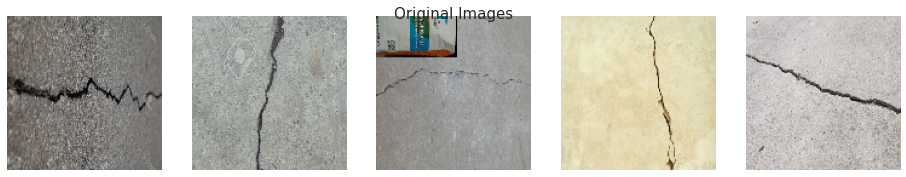

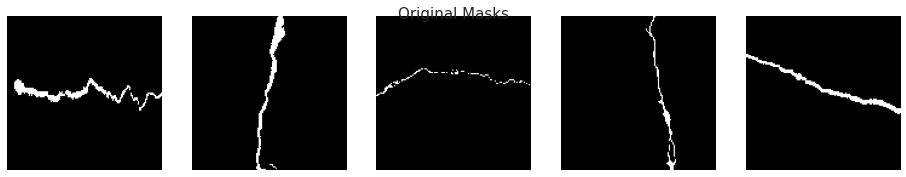

In [ ]:
# Train generator samples (Un-augmented)
for i, j in train_generator:
    break

# j=j.reshape(j.shape[1],j.shape[2],j.shape[3])
# j=j.reshape(j.shape[0],j.shape[1],j.shape[2],1)

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

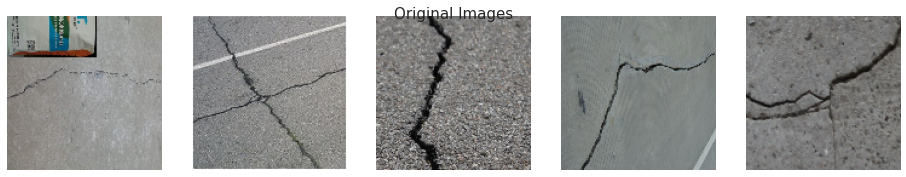

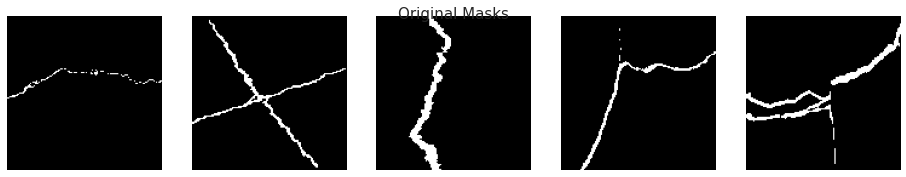

In [ ]:
# Validation generator samples (Un-augmented)
for i, j in validation_generator:
    break
# j=j.reshape(j.shape[1],j.shape[2],j.shape[3])
# j=j.reshape(j.shape[0],j.shape[1],j.shape[2],1)

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

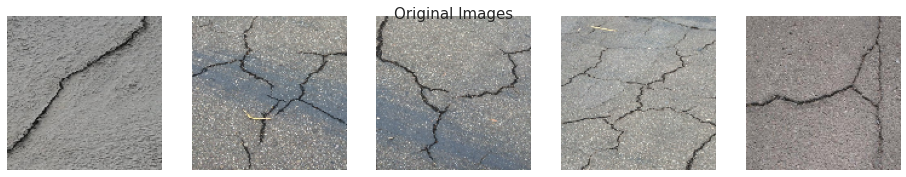

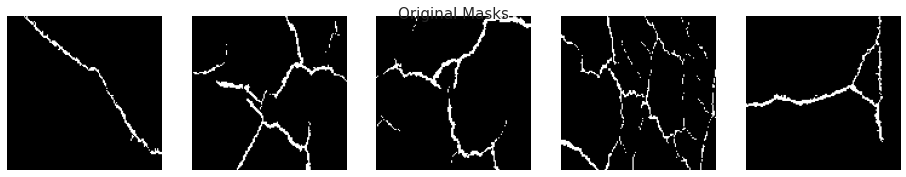

In [ ]:
# test generator samples (Un-augmented)
for i, j in test_generator:
    break
# j=j.reshape(j.shape[1],j.shape[2],j.shape[3])
# j=j.reshape(j.shape[0],j.shape[1],j.shape[2],1)

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
tg = Generator(train_image_files, train_mask_files, batch_size, img_dim, augment = True)
vg = Generator(valid_image_files, valid_mask_files, batch_size, img_dim, augment = False)
testg=Generator(test_image_paths,test_mask_paths,batch_size,img_dim,augment=False)

In [ ]:
for i, j in tg:
  break

print(i.shape)
print(j.shape)

(10, 256, 256, 3)
(10, 256, 256, 1)


In [ ]:
for i, j in vg:
  break

print(i.shape)
print(j.shape)

(10, 256, 256, 3)
(10, 256, 256, 1)


In [ ]:
for i, j in testg:
  break

print(i.shape)
print(j.shape)

(10, 256, 256, 3)
(10, 256, 256, 1)


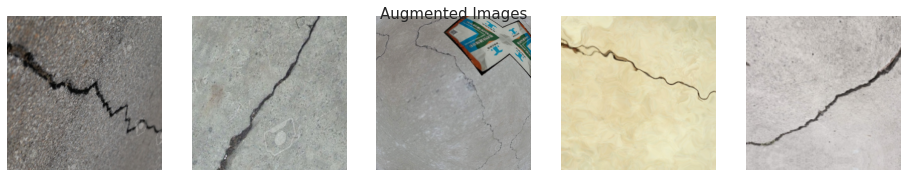

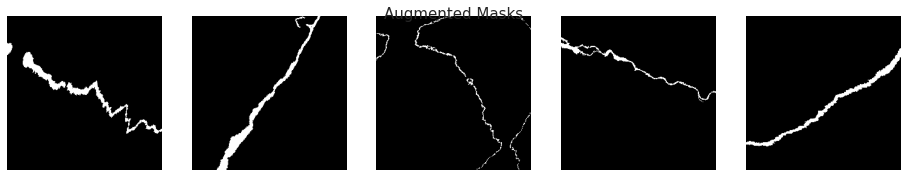

In [ ]:
# Augmented train
for i, j in tg:
    break
# j=j.reshape(j.shape[1],j.shape[2],j.shape[3])
# j=j.reshape(j.shape[0],j.shape[1],j.shape[2],1)

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Augmented Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Augmented Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Model architecture (**)

In [ ]:
# BatchNormalization and Activation
def BN_Act(x, act = True):
    x = BatchNormalization()(x)
    if act == True:
        x = Activation("relu")(x)
    return x

In [ ]:
# conv2d block
def conv2d_block(x, filters, kernel_size = (3, 3), padding = "same", strides = 1):
    conv = BN_Act(x)
    conv = Conv2D(filters, kernel_size, padding = padding, strides = strides)(conv)
    return conv

In [ ]:
# Fixed layer
def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, padding = padding, strides = strides)(x)
    conv = conv2d_block(conv, filters, kernel_size = kernel_size, padding = padding, strides = strides)
    
    #skip
    shortcut = Conv2D(filters, kernel_size = (1, 1), padding = padding, strides = strides)(x)
    shortcut = BN_Act(shortcut, act = False) # No activation in skip connection
    
    output = Add()([conv, shortcut])
    return output

In [ ]:
#Residual Block
def residual_block(x, filters, kernel_size = (3, 3), padding = "same", strides = 1):
    res = conv2d_block(x, filters, kernel_size = kernel_size, padding = padding, strides = strides)
    res = conv2d_block(res, filters, kernel_size = kernel_size, padding = padding, strides = 1)
    
    shortcut = Conv2D(filters, kernel_size = (1, 1), padding = padding, strides = strides)(x)
    shortcut = BN_Act(shortcut, act = False) # No activation in skip connection
    
    output = Add()([shortcut, res])
    return output

In [ ]:
#Upsample concatenation block
def upsample_concat_block(x, xskip):
    u = UpSampling2D((2, 2))(x)
    c = Concatenate()([u, xskip])
    return c

In [ ]:
# Complete model Architecture
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = Input((img_dim[0], img_dim[1], 3))
    
    ## Encoder/downsampling/contracting path
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides = 2)
    e3 = residual_block(e2, f[2], strides = 2)
    e4 = residual_block(e3, f[3], strides = 2)
    e5 = residual_block(e4, f[4], strides = 2)
    
    ## Bridge/Bottleneck
    b0 = conv2d_block(e5, f[4], strides = 1)
    b1 = conv2d_block(b0, f[4], strides = 1)
    
    ## Decoder/upsampling/expansive path
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = Conv2D(1, (1, 1), padding = "same", activation = "sigmoid")(d4)
    model = Model(inputs, outputs)
    return model

## Model train/test

### Instantiate the model (**)

In [ ]:
K.clear_session()
model = ResUNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

### Custom loss Function (**)


In [ ]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def IOU(y_true, y_pred):

    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    thresh = 0.5

    y_true = K.cast(K.greater_equal(y_true, thresh), 'float32')
    y_pred = K.cast(K.greater_equal(y_pred, thresh), 'float32')

    union = K.sum(K.maximum(y_true, y_pred)) + K.epsilon()
    intersection = K.sum(K.minimum(y_true, y_pred)) + K.epsilon()

    iou = intersection/union

    return iou

# def bce_dice_loss(y_true, y_pred):

#     return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

### Compile the model (**)

In [ ]:
def lr_schedule(epoch):
    lr =0.001
    if epoch >150:
        lr *=2**-1
    elif epoch >80:
        lr *=2**(-1)
    elif epoch >50:
        lr *=2**(-1)
    elif epoch >30:
        lr *=2**(-1)
    
    print('Learning rate: ', lr)
    return lr

In [ ]:
# start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-8)

callbacks = [lr_reducer, lr_scheduler]


In [ ]:
# Compiling with adam and beyond
learning_rate = 0.0035
optimiser=tf.keras.optimizers.legacy.Adam(
    learning_rate=lr_schedule(0),
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name="Adam"
)
model.compile(optimizer =optimiser , loss = dice_coef_loss, metrics = ['accuracy', IOU, dice_coef])

Learning rate:  0.001


### Training

In [ ]:
train_steps = len(train_image_files)//batch_size
valid_steps = len(valid_image_files)//batch_size

history = model.fit(
    tg, 
    steps_per_epoch=train_steps,
    initial_epoch = 0,
    epochs=100,
    validation_data = vg,    
    validation_steps = valid_steps,callbacks=callbacks)

Learning rate:  0.001
Epoch 1/100
27/27 [==============================] - 187s 7s/step - loss: 0.4637 - accuracy: 0.9193 - IOU: 0.4247 - dice_coef: 0.5363 - val_loss: 0.9838 - val_accuracy: 0.9676 - val_IOU: 0.0013 - val_dice_coef: 0.0162 - lr: 0.0010
Learning rate:  0.001
Epoch 2/100
27/27 [==============================] - 8s 274ms/step - loss: 0.2645 - accuracy: 0.9816 - IOU: 0.5926 - dice_coef: 0.7355 - val_loss: 0.9434 - val_accuracy: 0.9515 - val_IOU: 0.0286 - val_dice_coef: 0.0566 - lr: 0.0010
Learning rate:  0.001
Epoch 3/100
27/27 [==============================] - 8s 276ms/step - loss: 0.2605 - accuracy: 0.9819 - IOU: 0.5971 - dice_coef: 0.7395 - val_loss: 0.9952 - val_accuracy: 0.9684 - val_IOU: 4.8745e-12 - val_dice_coef: 0.0048 - lr: 0.0010
Learning rate:  0.001
Epoch 4/100
27/27 [==============================] - 8s 278ms/step - loss: 0.2475 - accuracy: 0.9826 - IOU: 0.6128 - dice_coef: 0.7525 - val_loss: 0.9777 - val_accuracy: 0.9684 - val_IOU: 2.8335e-04 - val_dice_coe

In [ ]:
# saving and loading the model weights
 
# save model
if Train:
  model.save_weights('/content/drive/MyDrive/Project TiHAN/PK DEEPCRACK WEIGHTS/')
  print('Model Saved!')
 
# load model
# savedModel = model.load_weights('PK DEEPCRACK WEIGHTS')
# print('Model Loaded!')

Model Saved!


In [ ]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

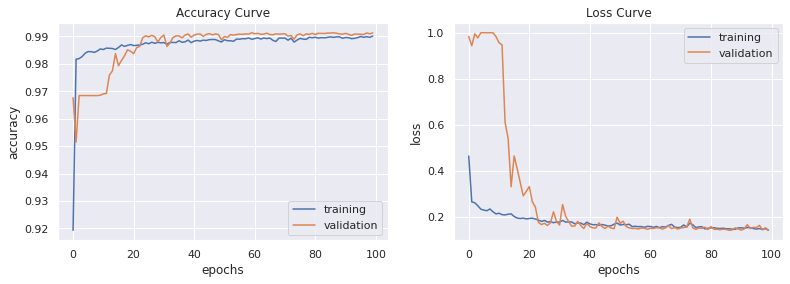

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13,4))
axes = axes.flatten()


axes[0].plot(train_acc, label='training')
axes[0].plot(valid_acc, label='validation')
axes[0].set_title('Accuracy Curve')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].legend()



axes[1].plot(train_loss, label='training')
axes[1].plot(valid_loss, label='validation')
axes[1].set_title('Loss Curve')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend()

plt.show()

In [ ]:
train_dice = history.history['dice_coef']
valid_dice = history.history['val_dice_coef']


train_IOU = history.history['IOU']
valid_IOU = history.history['val_IOU']

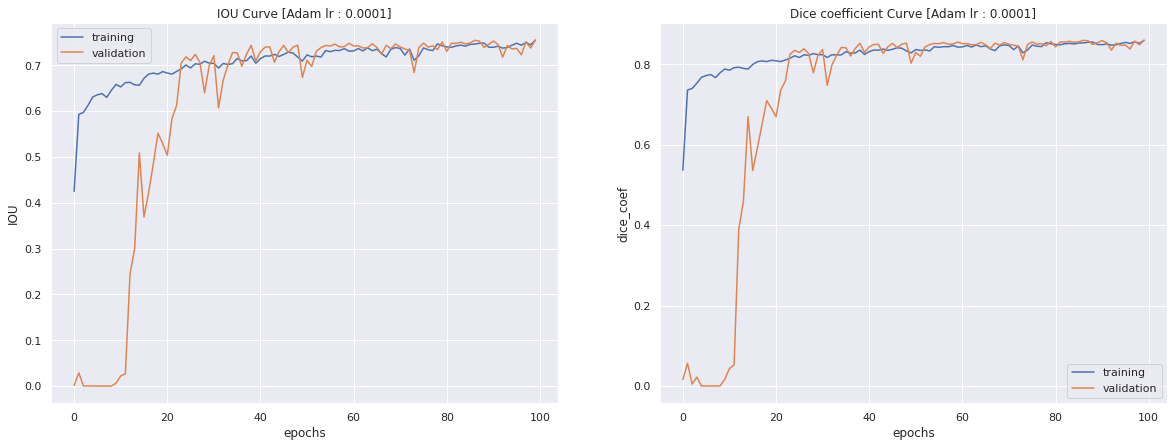

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))
axes = axes.flatten()

axes[0].plot(train_IOU, label='training')
axes[0].plot(valid_IOU, label='validation')
axes[0].set_title('IOU Curve [Adam lr : 0.0001]')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('IOU')
axes[0].legend()


axes[1].plot(train_dice, label='training')
axes[1].plot(valid_dice, label='validation')
axes[1].set_title('Dice coefficient Curve [Adam lr : 0.0001]')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('dice_coef')
axes[1].legend()

plt.show()

### Testing

In [ ]:
test_generator = Generator(test_image_paths, test_mask_paths,237, img_dim)

for x_test, y_test in test_generator:
  break

y_pred = model.predict(x_test)

yy_true = (y_test>0.5).flatten()
yy_pred = (y_pred>0.5).flatten()

In [ ]:
report = classification_report(yy_true, yy_pred, output_dict=True)

Accuracy = accuracy_score(yy_true, yy_pred)

Precision = report['True']['precision']
Recall = report['True']['recall']
F1_score = report['True']['f1-score']

Sensitivity = Recall
Specificity = report['False']['recall']

AUC = roc_auc_score(y_test.flatten(), y_pred.flatten())

IOU = (Precision*Recall)/(Precision+Recall-Precision*Recall)

print("Accuracy: {0:.4f}\n".format(Accuracy))
print("Precision: {0:.4f}\n".format(Precision))
print("Recall: {0:.4f}\n".format(Recall))
print("F1-Score: {0:.4f}\n".format(F1_score))
print("Sensitivity: {0:.4f}\n".format(Sensitivity))
print("Specificity: {0:.4f}\n".format(Specificity))
print("AUC: {0:.4f}\n".format(AUC))
print("IOU: {0:.4f}\n".format(IOU))
print('-'*50,'\n')
print(classification_report(yy_true, yy_pred))

Accuracy: 0.9745

Precision: 0.7641

Recall: 0.6837

F1-Score: 0.7217

Sensitivity: 0.6837

Specificity: 0.9893

AUC: 0.8668

IOU: 0.5645

-------------------------------------------------- 

              precision    recall  f1-score   support

       False       0.98      0.99      0.99  14780073
        True       0.76      0.68      0.72    751959

    accuracy                           0.97  15532032
   macro avg       0.87      0.84      0.85  15532032
weighted avg       0.97      0.97      0.97  15532032



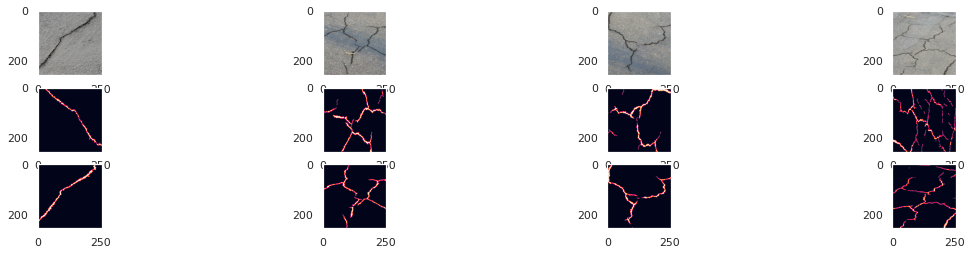

In [ ]:
test_generator = Generator(test_image_paths, test_mask_paths,237, img_dim)

for x_test, y_test in test_generator:
  break

y_pred = model.predict(x_test)

plt.figure(figsize=(40, 4))
for i in range(4):
    # display image
    plt.grid(False)
    ax = plt.subplot(3, 8, i + 1)
    plt.imshow(x_test[i])
    # display original label
    plt.grid(False)
    ax = plt.subplot(3, 8, 8+i + 1)
    plt.imshow(y_test[i][:,:,0])
    
    # display reconstructed (after noise removed) image
    plt.grid(False)
    ax = plt.subplot(3, 8, 16 +i+ 1)
    plt.imshow(y_pred[i][:,:,0])

plt.grid(False)
plt.show()

In [ ]:
print(x_test.shape)
print(y_test.shape)
print(y_pred.shape)

(237, 256, 256, 3)
(237, 256, 256, 1)
(237, 256, 256, 1)


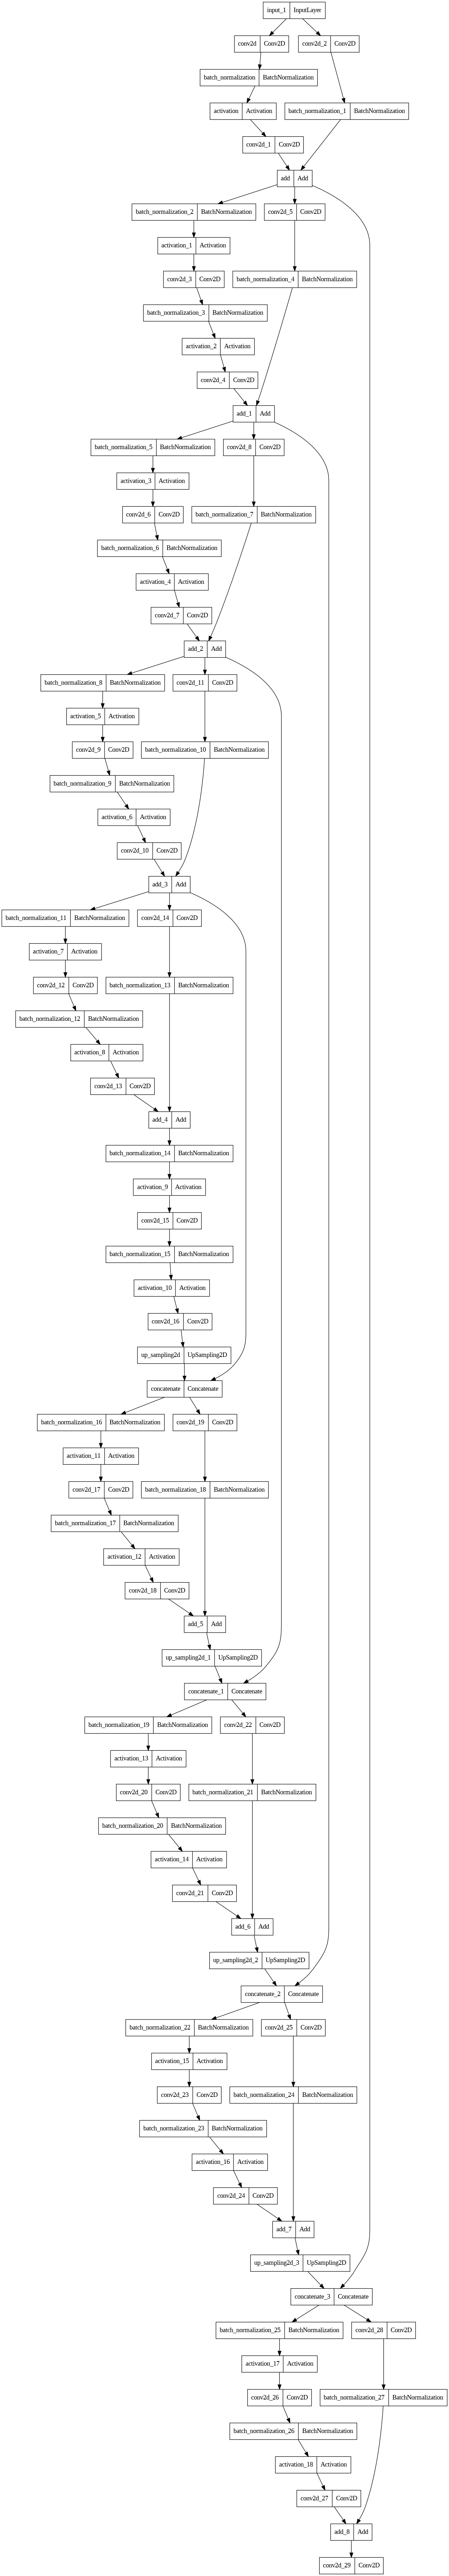

In [ ]:
tf.keras.utils.plot_model(model)



In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

## Testing with new images (**)

In [ ]:
# # campus_image_dir = r'/home/ubuntu/Desktop/NNDL Project/campus_crack'
# # load saved model or if you are training, pls comment below 4 lines 
# if ~Train:
#   model.load_weights('/content/drive/MyDrive/Project TiHAN/PK DEEPCRACK WEIGHTS/')
# path = r'/content/drive/MyDrive/Integral_Code_files/Overlaid_Images/'
# pipe_image_paths = sorted([os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith(".jpg") or fname.endswith(".png") or fname.endswith(".jpeg") and not fname.startswith(".")])
# pipe = Generator(pipe_image_paths, pipe_image_paths, len(pipe_image_paths), img_dim, augment = False)
# for p_test, y_test in pipe:
#     break
# #print(images.shape)

# pipe_pred = model.predict(p_test)

# n=len(p_test)


# # for i in range(n):
# #     # display image
# #     plt.figure(figsize=(8, 8))
# #     plt.grid(False)
# #     plt.axis("off")
# #     ax = plt.subplot(1,2,1)
# #     plt.imshow(p_test[i])
    
# #     # display reconstructed (after noise removed) image
# #     #plt.grid(False)
# #     plt.subplot(1, 2,  2)
# #     plt.imshow(pipe_pred[i][:,:,0])
# #     plt.savefig("/content/drive/MyDrive/EarlierCracksPrediction/True-Prediction{}".format(i+1))
# #     plt.show()



USING THE BELOW ONE AS AN ALTERNATE TO THE ABOVE ONE

In [ ]:
if ~Train:
  model.load_weights('/content/drive/MyDrive/Project TiHAN/PK DEEPCRACK WEIGHTS/')
path = r'/content/drive/MyDrive/Integral_Code_files/Overlaid_Images/'


from PIL import Image
import os

image_extensions = [".jpg", ".jpeg", ".png"]

def is_image_file(filename):
    return any(filename.endswith(ext) for ext in image_extensions)

def get_image_files(path):
    return [os.path.join(path, f) for f in os.listdir(path) if is_image_file(f) and not f.startswith(".")]

pipe_image_paths = sorted(get_image_files(path))
print(pipe_image_paths) #remove this line later


def sort_func(s):
    return int(s.split("Overlaid1_Tiled_")[-1].split(".jpg")[0]) #THIS MUST BE NAMED ACCORDINGLY (After "Overlaid" in this line, type the name of the input image in the "Crack_Raw_Pictures" folder)

pipe_image_paths.sort(key=sort_func)

print(pipe_image_paths) #remove this line later


pipe = Generator(pipe_image_paths, pipe_image_paths, len(pipe_image_paths), img_dim, augment = False)
for p_test, y_test in pipe:
    break
#print(images.shape)

pipe_pred = model.predict(p_test)


n=len(p_test)

['/content/drive/MyDrive/Integral_Code_files/Overlaid_Images/Overlaid1_Tiled_1.jpg', '/content/drive/MyDrive/Integral_Code_files/Overlaid_Images/Overlaid1_Tiled_2.jpg', '/content/drive/MyDrive/Integral_Code_files/Overlaid_Images/Overlaid1_Tiled_3.jpg', '/content/drive/MyDrive/Integral_Code_files/Overlaid_Images/Overlaid1_Tiled_4.jpg', '/content/drive/MyDrive/Integral_Code_files/Overlaid_Images/Overlaid1_Tiled_5.jpg', '/content/drive/MyDrive/Integral_Code_files/Overlaid_Images/Overlaid1_Tiled_6.jpg']
['/content/drive/MyDrive/Integral_Code_files/Overlaid_Images/Overlaid1_Tiled_1.jpg', '/content/drive/MyDrive/Integral_Code_files/Overlaid_Images/Overlaid1_Tiled_2.jpg', '/content/drive/MyDrive/Integral_Code_files/Overlaid_Images/Overlaid1_Tiled_3.jpg', '/content/drive/MyDrive/Integral_Code_files/Overlaid_Images/Overlaid1_Tiled_4.jpg', '/content/drive/MyDrive/Integral_Code_files/Overlaid_Images/Overlaid1_Tiled_5.jpg', '/content/drive/MyDrive/Integral_Code_files/Overlaid_Images/Overlaid1_Tile

In [ ]:
for i in range(n):
  cv2.imwrite("/content/drive/MyDrive/Integral_Code_files/CNN_Output/Prediction{}.jpg".format(i+1), 255* pipe_pred[i]) # multiplied by 255 because the array had values b/w 0-1 but imwrite requires the range b/w 0-255

In [ ]:
# for i in range(n):
#     # display image
#     plt.figure(figsize=(8, 8))
#     plt.axis("off")
#     ax = plt.subplot(1,2,1)
#     plt.grid(False)
#     plt.imshow(p_test[i])
    
#     # display reconstructed (after noise removed) image
    
#     plt.subplot(1, 2, 2)
#     plt.imshow(pipe_pred[i][:,:,0])
#     plt.grid(False)
 

#     plt.savefig("/content/drive/MyDrive/EarlierCracksPrediction/True-Prediction{}".format(i+1))
#     plt.show()



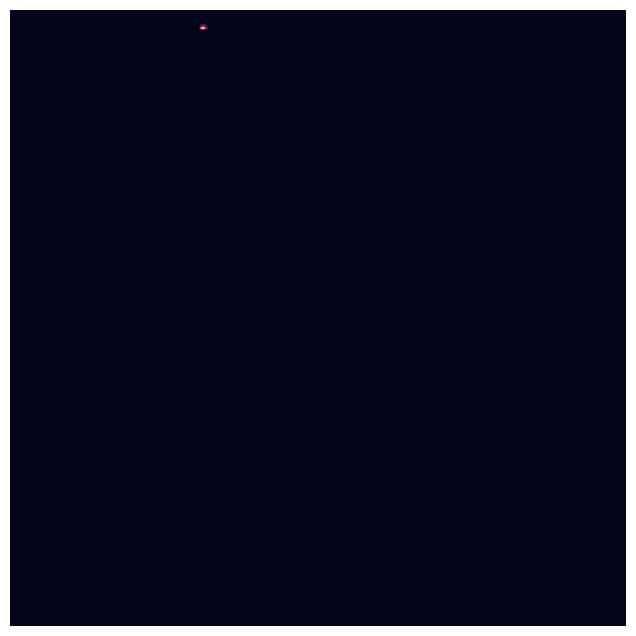

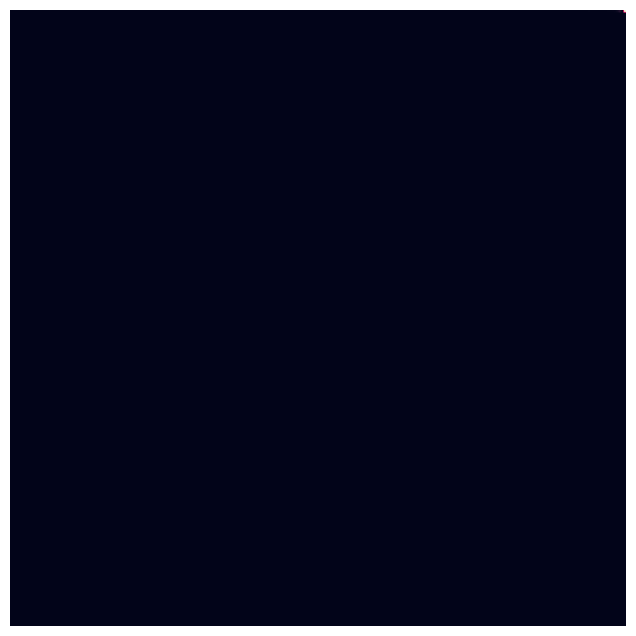

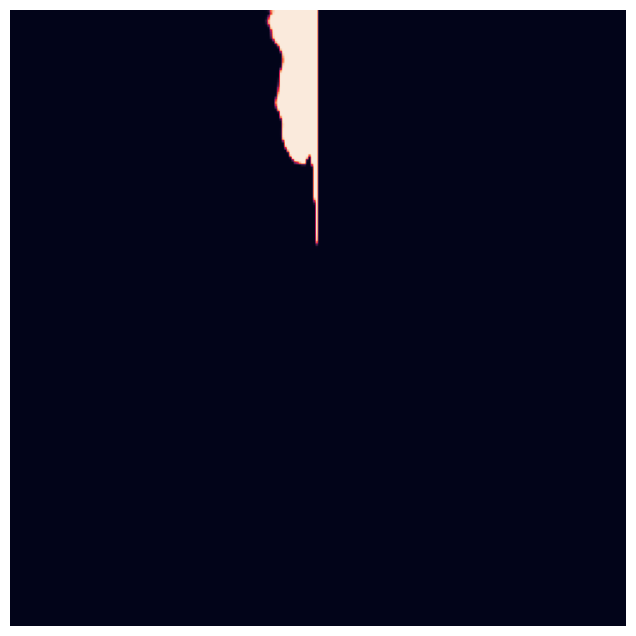

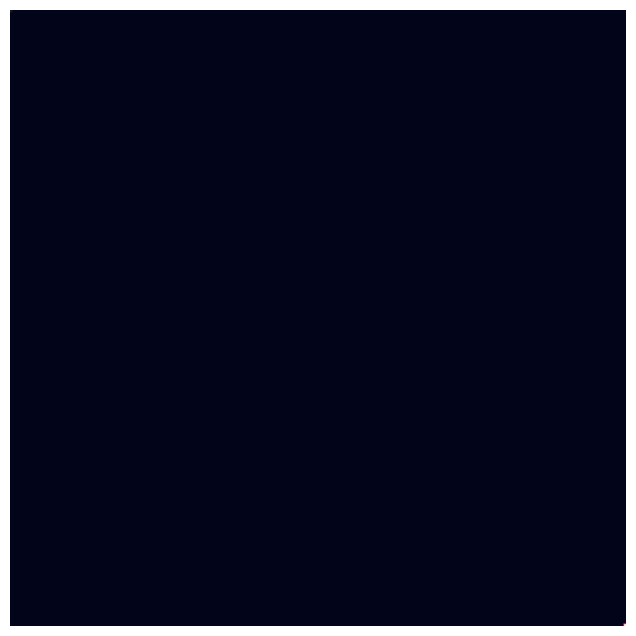

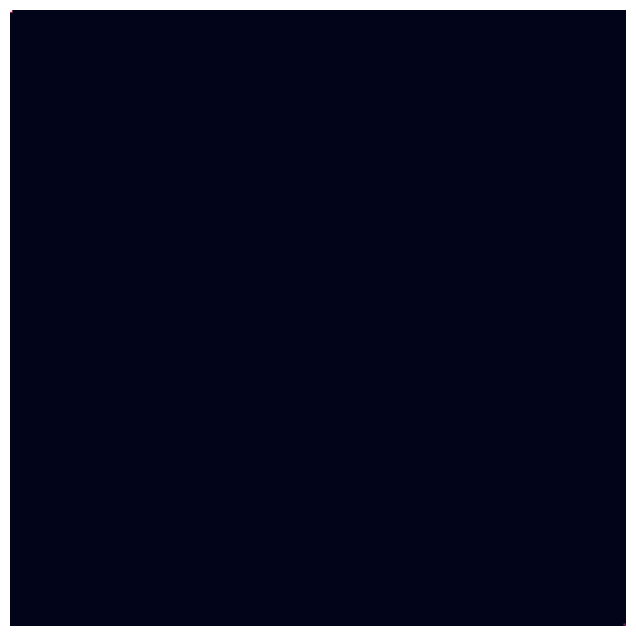

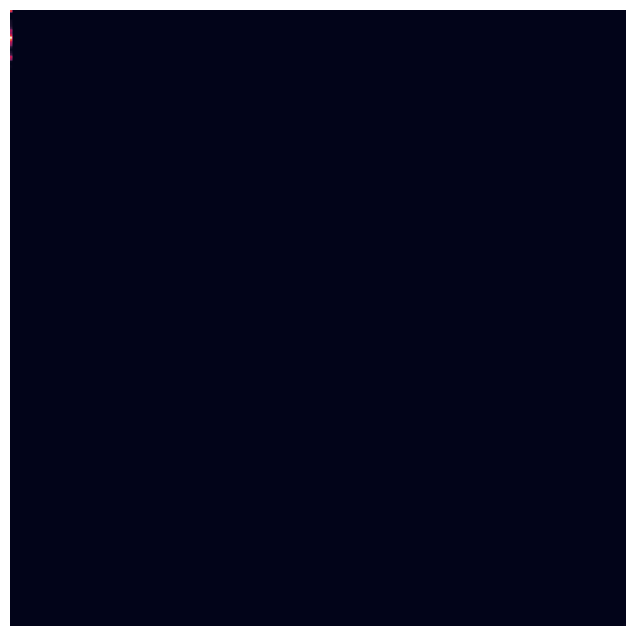

In [ ]:
for i in range(n):
    # display image
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.grid(False)
    
    
    # display reconstructed (after noise removed) image
    plt.imshow(pipe_pred[i][:,:,0])
 
    # plt.savefig("/content/drive/MyDrive/EarlierCracksPrediction/Prediction{}".format(i+1))
    # plt.savefig("/content/drive/MyDrive/Integral_Code_files/CNN_Output/Prediction{}".format(i+1))
    plt.show()



## Extra

In [ ]:
# path = r'C:\Users\IIT\Desktop\Picture2.jpg'
# pipe_image_paths = sorted([os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith(".jpg") and not fname.startswith(".")])

# pipe = Generator(pipe_image_paths, pipe_image_paths, batch_size, img_dim, augment = False)
# for p_test, y_test in pipe:
#     break
# #print(images.shape)

# pipe_pred = model.predict(p_test)

# n=len(p_test)
# # plt.subplot(9,3,1)
# # plt.imshow(p_test[3])
# # plt.subplot(9,3,2)
# # plt.imshow(pipe_pred[3])
# plt.figure(figsize=(40, 40))
# for i in range(n):
#     # display image
#     plt.grid(False)
#     plt.subplot(n,2,2*i+1)
#     plt.imshow(p_test[i])
# #     # display original label
# #     ax = plt.subplot(3, 8, 8+i + 1)
# #     plt.imshow(y_test[i])
    
#     # display reconstructed (after noise removed) image
#     plt.grid(False)
#     plt.subplot(n, 2,  2*(i+1))
#     plt.imshow(pipe_pred[i])

# plt.grid(False)
# plt.show()

In [ ]:
# path = r'/home/ubuntu/Desktop/NNDL Project/PAVEMENT NEW 256'
# pipe_image_paths = sorted([os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith(".jpg") and not fname.startswith(".")])

# pipe = Generator(pipe_image_paths, pipe_image_paths, batch_size, img_dim, augment = False)
# for p_test, y_test in pipe:
#     break
# #print(images.shape)

# pipe_pred = model.predict(p_test)

# n=len(p_test)
# # plt.subplot(9,3,1)
# # plt.imshow(p_test[3])
# # plt.subplot(9,3,2)
# # plt.imshow(pipe_pred[3])
# plt.figure(figsize=(40, 40))
# for i in range(n):
#     # display image
#     plt.grid(False)
#     plt.subplot(n,2,2*i+1)
#     plt.imshow(p_test[i])
# #     # display original label
# #     ax = plt.subplot(3, 8, 8+i + 1)
# #     plt.imshow(y_test[i])
    
#     # display reconstructed (after noise removed) image
#     plt.grid(False)
#     plt.subplot(n, 2,  2*(i+1))
#     plt.imshow(pipe_pred[i])

# plt.grid(False)
# plt.show()

In [ ]:
# path = r'/home/ubuntu/Desktop/NNDL Project/WALL NEW 256'
# pipe_image_paths = sorted([os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith(".jpg") and not fname.startswith(".")])

# pipe = Generator(pipe_image_paths, pipe_image_paths, batch_size, img_dim, augment = False)
# for p_test, y_test in pipe:
#     break
# #print(images.shape)

# pipe_pred = model.predict(p_test)

# n=len(p_test)
# # plt.subplot(9,3,1)
# # plt.imshow(p_test[3])
# # plt.subplot(9,3,2)
# # plt.imshow(pipe_pred[3])
# plt.figure(figsize=(40, 40))
# for i in range(n):
#     # display image
#     plt.grid(False)
#     plt.subplot(n,2,2*i+1)
#     plt.imshow(p_test[i])
# #     # display original label
# #     ax = plt.subplot(3, 8, 8+i + 1)
# #     plt.imshow(y_test[i])
    
#     # display reconstructed (after noise removed) image
#     plt.grid(False)
#     plt.subplot(n, 2,  2*(i+1))
#     plt.imshow(pipe_pred[i])

# plt.grid(False)
# plt.show()

In [ ]:
# path = r'/home/ubuntu/Desktop/NNDL Project/PIPE NEW 256'
# pipe_image_paths = sorted([os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith(".jpg") and not fname.startswith(".")])

# test_lab_path = r'/home/ubuntu/Desktop/NNDL Project/Pipe GT'
# pipe_lab_paths = sorted([os.path.join(test_lab_path, fname) for fname in os.listdir(test_lab_path) if fname.endswith(".jpg") and not fname.startswith(".")])


# pipe = Generator(pipe_image_paths, pipe_lab_paths, 9, img_dim, augment = False)
# for p_test, y_test in pipe:
#     break
# print(p_test.shape)
# print(y_test.shape)
# y_test = y_test.reshape(y_test.shape[0],y_test.shape[1],y_test.shape[2],y_test.shape[3])
# print(y_test.shape)
# y_test = np.expand_dims(y_test[:,:,:,0], axis = -1)
# print(y_test.shape)

# y_pred = model.predict(p_test)

# yy_true = (y_test>0.5).flatten()
# yy_pred = (y_pred>0.5).flatten()

# print(yy_true.shape)
# print(yy_pred.shape)

# print((y_test.flatten().shape))
# print((y_pred.flatten().shape))

# report = classification_report(yy_true, yy_pred, output_dict=True)

# Accuracy = accuracy_score(yy_true, yy_pred)

# Precision = report['True']['precision']
# Recall = report['True']['recall']
# F1_score = report['True']['f1-score']

# Sensitivity = Recall
# Specificity = report['False']['recall']

# AUC = roc_auc_score(y_test.flatten(), y_pred.flatten())

# IOU = (Precision*Recall)/(Precision+Recall-Precision*Recall)

# print("Accuracy: {0:.4f}\n".format(Accuracy))
# print("Precision: {0:.4f}\n".format(Precision))
# print("Recall: {0:.4f}\n".format(Recall))
# print("F1-Score: {0:.4f}\n".format(F1_score))
# print("Sensitivity: {0:.4f}\n".format(Sensitivity))
# print("Specificity: {0:.4f}\n".format(Specificity))
# print("AUC: {0:.4f}\n".format(AUC))
# print("IOU: {0:.4f}\n".format(IOU))
# print('-'*50,'\n')
# print(classification_report(yy_true, yy_pred))

# n=len(p_test)

# plt.figure(figsize=(20, 20))

# for i in range(n):
#     # display image
#     plt.grid(False)
#     plt.subplot(n,3,3*i+1)
#     plt.imshow(p_test[i])
    
#     plt.grid(False)
#     plt.subplot(n,3,3*i+2)
#     plt.imshow(y_test[i])
    
#     # display reconstructed (after noise removed) image
#     plt.grid(False)
#     plt.subplot(n, 3,  3*(i+1))
#     plt.imshow(y_pred[i])

# plt.grid(False)    
# plt.show()

In [ ]:
# # path = r'/home/ubuntu/Desktop/NNDL Project/WALL NEW 256'
# # path = r'/home/ubuntu/Desktop/NNDL Project/PAVEMENT NEW 256'
# path = r'/home/ubuntu/Desktop/NNDL Project/PIPE NEW 256'
# pipe_image_paths = sorted([os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith(".jpg") and not fname.startswith(".")])

# pipe = Generator(pipe_image_paths, pipe_image_paths, batch_size, img_dim, augment = False)
# for p_test, y_test in pipe:
#     break
# #print(images.shape)

# pipe_pred = model.predict(p_test)

# n=len(p_test)
# # plt.subplot(9,3,1)
# # plt.imshow(p_test[3])
# # plt.subplot(9,3,2)
# plt.imshow(pipe_pred[8])
# # plt.figure(figsize=(40, 40))
# # for i in range(n):
# #     # display image
# #     plt.subplot(n,2,2*i+1)
# #     plt.imshow(p_test[i])
# # #     # display original label
# # #     ax = plt.subplot(3, 8, 8+i + 1)
# # #     plt.imshow(y_test[i])
    
# #     # display reconstructed (after noise removed) image
# #     plt.subplot(n, 2,  2*(i+1))
# #     plt.imshow(pipe_pred[i])

# plt.show()